## Imports

In [9]:
from helpers.pc2dem import generate_dem_from_dict_v2, generate_chm
import json, os
import itertools

In [12]:
# PATHS

# code/ is where my notebooks are
# /pipeline is the folder that contains json files

# base of the bases' folders 
# ROOT: project folder's path
# OUTPUT: related results of dtm/dem - dsm
# SAMPLES : contains base data which is .laz
ROOT = "/home/metin/Desktop/workshop/carbon/carbon.v1"
OUTPUT = "outputs"
SAMPLES = "samples"

PNG_PATH = "png"

OUTPUT_PATH = os.path.join(
    ROOT, OUTPUT
)


## Getting Needed Json Pipelines 

In [10]:
dtm_json = os.path.join(
    "/home/metin/Desktop/workshop/carbon/carbon.v1/code/pipeline/",
    "dtm.json"
)
dsm_json = os.path.join(
    "/home/metin/Desktop/workshop/carbon/carbon.v1/code/pipeline/",
    "dsm.json"
)

f_terrain = open(dtm_json)
f_surface = open(dsm_json)

dtm_data = json.load(f_terrain)
dsm_data = json.load(f_surface)

dtm_pipeline = dtm_data["pipeline"]
dsm_pipeline = dsm_data["pipeline"]


In [37]:
os.path.exists(dsm_json)

True

## Dictionary of the Values of Parameters

In [11]:
# Good to note that this dictionary is the list of 
# values of parameters that I want to optimize.
# Not the dictionary that I will use for optimization step
param_dict_list = {
    # Fixed Values
    "input_path":["/home/metin/Desktop/workshop/carbon/carbon.v1/samples/pcd/low - 1.laz"],
    
    # will change for every combination values 
    "filename":["/home/metin/Desktop/workshop/carbon/carbon.v1/outputs"],
    
    # Labeling Algorithm Params
    "slope":["0.10", "0.30"],
    "window": ["14", "16"],
    "threshold":["0.30", "0.50", "1.0"],
    "scalar": ["1.0", "1.25", "1.75"],
    "returns": ["first, only"],
    
    # writers params
    "output_type": ["idw", "all"],
    "window_size": [0, 1],
    
}

There is total of 144 combination from params above. Since my hardware is limited, I'll simply drop the number of combination to 144 from 2187 (3^7).

In [14]:
# Creating dictionary for DSM
param_dict_dsm = {}
dsm_param_names = ["filename","window_size","power",
                   "output_type", "input_path"]

for param in dsm_param_names:
    if param in param_dict_list.keys():
        param_dict_dsm[param] = param_dict_list[param]

param_dict_dsm["power"] = [0, 3, 5] 
param_dict_dsm["window_size"] = [0, 1, 5]

{'filename': ['/home/metin/Desktop/workshop/carbon/carbon.v1/outputs'],
 'window_size': [0, 1, 5],
 'output_type': ['idw', 'all'],
 'input_path': ['/home/metin/Desktop/workshop/carbon/carbon.v1/samples/pcd/low - 1.laz'],
 'power': [0, 3, 5]}

## Time to loop up.

In [13]:
# Declaring the models that we going to extract in a minute
steps = ["dtm", "dsm", "chm"]

In [19]:
parts = dtm_pipeline[::-1][1:3]
parts_dtm = dsm_pipeline[::-1][0]

In [ ]:

for step in steps:
    if step == "dtm":
        for index,combination in enumerate(itertools.product(*param_dict_list.values())):
            one_combination = {}
            for param_name, param_value in zip(param_dict_list.keys(), combination):
                one_combination[param_name] = param_value

            # Process or store the current parameter combination
            #print(json.dumps(one_combination, indent=4))
            name = "DTM-"+str(index)+".tif"
            output_path = os.path.join(
                one_combination["filename"],"dtm" ,name
            )
            # We set the input_path to the point cloud that we'll use in pipeline
            dtm_pipeline[0] = one_combination["input_path"]

            for Index, i in enumerate(parts):
                for j in i.keys():
                    if j in one_combination.keys():
                        if j == "filename":
                            parts[Index][j] = output_path
                        else:
                            parts[Index][j] = one_combination[j]

            dtm_pipeline[::-1][1:3] = parts
            dtm_data["pipeline"] = dtm_pipeline
                    
            # Generation Part
            generate_dem_from_dict_v2(pipeline_dict=dtm_pipeline)

        print("DTM generated.")
        
    elif step == "dsm":
        for index, combination in enumerate(itertools.product(*param_dict_dsm)):
            one_combination= {}
            for param_name, param_value in zip(param_dict_dsm.keys(), combination):
                one_combination[param_name] = param_value
                
            name = "DSM-"+str(index)+".tif"
            output_path = os.path.join(
                one_combination["filename"],"dsm" ,name
            )
            
            dsm_pipeline[0] = one_combination["input_path"]
            
            for Index, i in enumerate(parts_dtm):
                for j in i.keys():
                    if j in one_combination.keys():
                        if j == "filename":
                            parts_dtm[Index][j] = output_path
                        else:
                            parts_dtm[Index][j] = one_combination[j]


            dsm_pipeline[::-1][1:3] = parts_dtm
            dtm_data["pipeline"] = dsm_pipeline

            generate_dem_from_dict_v2(pipeline_dict=dsm_pipeline)
        
        print("DSM generated.")

    else:
        DTM_PATH = os.path.join(
            OUTPUT_PATH, "dtm"
        )
        
        DSM_PATH = os.path.join(
            OUTPUT_PATH, "dsm"
        )
        
        OUTPUT_PATH = os.path.join(
            OUTPUT_PATH, "canopy"
        )
        
        generate_chm(DTM_PATH = DTM_PATH,
                     DSM_PATH = DSM_PATH,
                     OUTPUT_PATH = OUTPUT_PATH,
                     save_png=True)
        
        print("Needed CHM's are generated from extracted models . . .")

## Visualization of the needed model.

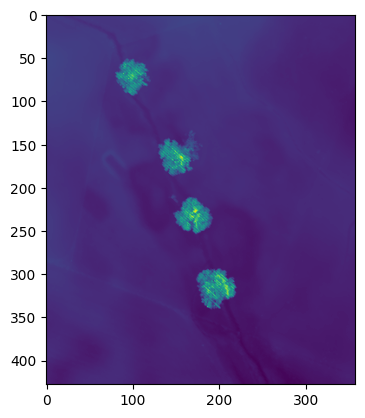

In [14]:
PEATH = "/home/metin/Desktop/workshop/carbon/carbon.v1/outputs/dtm/DTM-25.tif"

from osgeo import gdal
import matplotlib.pyplot as plt

data= gdal.Open(PEATH)

BAND1 = data.GetRasterBand(1)
b1 = BAND1.ReadAsArray()

plt.imshow(b1)